In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import pickle
import phate
import scipy
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from numpy import savetxt
import scprep

## Functions

In [2]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:, :dim]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O

def compute_curvature(point_cloud, query_point, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    
    ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point, epsilon_PCA = epsilon_PCA,
                                                                    dim = dim, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), dim, dim))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []

    O_init = O[0].T  # this is the basis at point o, it is 2 x 3
    v_init =  tau_neighbor[1] - tau_neighbor[0] #choose the initial vector
    v_0 = np.array([np.dot(v_init, O_init[0]), np.dot(v_init, O_init[1])]) #change that vector to the coord w.r.t the basis O_init
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            v_fin = transport_maps[j, 0] @ transport_maps[i, j] @ transport_maps[0, i] @ v_0 #final vector of the form (a, b)
            v_fin = v_fin[0] * O_init[0] + v_fin[1] * O_init[1]  #change it to the vector form of coord (x, y, z)
            
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            if cosin>1: cosin = 1
            if cosin<-1: cosin = -1
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
            #tensor = angle / area
            tensor = (2 * np.pi - angle) / area 
            
            tensor_av.append(tensor)
            
            #tensor = angle / area                                  

    
    
    tensor_av = np.exp(sum(tensor_av)/len(tensor_av) * 0.0001)
         
    return transport_maps, tensor_av 

## EB Data

In [3]:
import os
import scprep
download_path = os.path.expanduser("data/")
print(download_path)

data/


In [4]:
sparse=True
T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

RP11-34P13.3 (ENSG00000243485)  FAM138A (ENSG00000237613)  \
0                                                                             
AAACATACCAGAGG-1                             0.0                        0.0   
AAACATTGAAAGCA-1                             0.0                        0.0   
AAACATTGAAGTGA-1                             0.0                        0.0   
AAACATTGGAGGTG-1                             0.0                        0.0   
AAACATTGGTTTCT-1                             0.0                        0.0   

                  OR4F5 (ENSG00000186092)  RP11-34P13.7 (ENSG00000238009)  \
0                                                                           
AAACATACCAGAGG-1                      0.0                             0.0   
AAACATTGAAAGCA-1                      0.0                             0.0   
AAACATTGAAGTGA-1                      0.0                             0.0   
AAACATTGGAGGTG-1                      0.0                             0.0   
AAACATTGGTTTCT-1                      0.0                             0.0   

                  RP11-34P13.8 (ENSG00000239945)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  RP11-34P13.14 (ENSG00000239906)  \
0                                                   
AAACATACCAGAGG-1                              0.0   
AAACATTGAAAGCA-1                              0.0   
AAACATTGAAGTGA-1                              0.0   
AAACATTGGAGGTG-1                              0.0   
AAACATTGGTTTCT-1                              0.0   

                  RP11-34P13.9 (ENSG00000241599)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  FO538757.3 (ENSG00000279928)  FO538757.2 (ENSG00000279457)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           1.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AP006222.2 (ENSG00000228463)  ...  \
0                                               ...   
AAACATACCAGAGG-1                           0.0  ...   
AAACATTGAAAGCA-1                           0.0  ...   
AAACATTGAAGTGA-1                           0.0  ...   
AAACATTGGAGGTG-1                           0.0  ...   
AAACATTGGTTTCT-1                           0.0  ...   

                  AC007325.2 (ENSG00000277196)  BX072566.1 (ENSG00000277630)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AL354822.1 (ENSG00000278384)  AC023491.2 (ENSG00000278633)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0

In [5]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()

A1BG (ENSG00000121410)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0   

                            A1BG-AS1 (ENSG00000268895)  \
AAACATTGAAAGCA-1_Day 00-03                         0.0   
AAACCGTGCAGAAA-1_Day 00-03                         0.0   
AAACCGTGGAAGGC-1_Day 00-03                         0.0   
AAACGCACCGGTAT-1_Day 00-03                         0.0   
AAACGCACCTATTC-1_Day 00-03                         0.0   

                            A1CF (ENSG00000148584)  A2M (ENSG00000175899)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0                    0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0                    0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0                    0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0                    0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0                    0.0   

                            A2M-AS1 (ENSG00000245105)  \
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACCGTGCAGAAA-1_Day 00-03                        0.0   
AAACCGTGGAAGGC-1_Day 00-03                        0.0   
AAACGCACCGGTAT-1_Day 00-03                        0.0   
AAACGCACCTATTC-1_Day 00-03                        0.0   

                            A2ML1 (ENSG00000166535)  \
AAACATTGAAAGCA-1_Day 00-03                      0.0   
AAACCGTGCAGAAA-1_Day 00-03                      0.0   
AAACCGTGGAAGGC-1_Day 00-03                      0.0   
AAACGCACCGGTAT-1_Day 00-03                      0.0   
AAACGCACCTATTC-1_Day 00-03                      0.0   

                            A2ML1-AS1 (ENSG00000256661)  \
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACCGTGCAGAAA-1_Day 00-03                          0.0   
AAACCGTGGAAGGC-1_Day 00-03                          0.0   
AAACGCACCGGTAT-1_Day 00-03                          0.0   
AAACGCACCTATTC-1_Day 00-03                          0.0   

                            A2ML1-AS2 (ENSG00000256904)  \
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACCGTGCAGAAA-1_Day 00-03                          0.0   
AAACCGTGGAAGGC-1_Day 00-03                          0.0   
AAACGCACCGGTAT-1_Day 00-03                          0.0   
AAACGCACCTATTC-1_Day 00-03                          0.0   

                            A3GALT2 (ENSG00000184389)  \
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACCGTGCAGAAA-1_Day 00-03                        0.0   
AAACCGTGGAAGGC-1_Day 00-03                        0.0   
AAACGCACCGGTAT-1_Day 00-03                        0.0   
AAACGCACCTATTC-1_Day 00-03                        0.0   

                            A4GALT (ENSG00000128274)  ...  \
AAACATTGAAAGCA-1_Day 00-03                       0.0  ...   
AAACCGTGCAGAAA-1_Day 00-03                       0.0  ...   
AAACCGTGGAAGGC-1_Day 00-03                       0.0  ...   
AAACGCACCGGTAT-1_Day 00-03                       0.0  ...   
AAACGCACCTATTC-1_Day 00-03                       0.0  ...   

                            ZXDC (ENSG00000070476)  ZYG11A (ENSG00000203995)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0                       0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0                       0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0                       0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0                       0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0                       0.0   

                            ZYG11B (ENSG00000162378)  ZYX (ENSG00000159840)  \
AAACATTGAAAGCA-1_Day 00-03                       0.0                    0.0   
AAACCGTGCAGAAA-1_Day 00-03                       0.0                    0.0   
AAACCGTGGAAGGC-1_Day 00-03                       0.0                    0.0   


In [6]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

In [7]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

In [8]:
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.

In [9]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')

In [34]:
labels = sample_labels.map(dict(zip(sample_labels.unique(),np.arange(sample_labels.nunique())))).values
savetxt('ebdata_labels.csv', labels, delimiter=',')

In [16]:
EBT_counts = scprep.transform.sqrt(EBT_counts)

In [17]:
EBT_counts.shape

(16821, 17845)

In [12]:
phate_operator = phate.PHATE()

Y_phate = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 29.32 seconds.
    Calculating KNN search...
    Calculated KNN search in 24.26 seconds.
    Calculating affinities...
    Calculated affinities in 1.51 seconds.
  Calculated graph and diffusion operator in 55.90 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.33 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.93 seconds.
  Calculated landmark operator in 8.79 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 1.65 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.46 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.52 seconds.
Calculated PHATE in 71.33 seconds.


<AxesSubplot: xlabel='PHATE1', ylabel='PHATE2'>

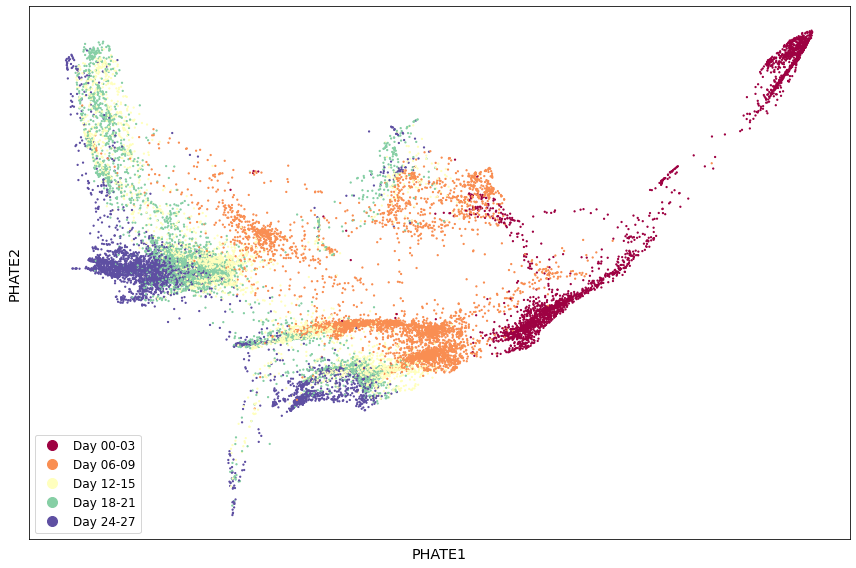

In [13]:
scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [23]:
savetxt('ebdata_2d.csv', Y_phate, delimiter=',')

In [14]:
phate_operator = phate.PHATE(n_components = 3)

Y_phate3d = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 28.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 24.49 seconds.
    Calculating affinities...
    Calculated affinities in 1.38 seconds.
  Calculated graph and diffusion operator in 54.99 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.43 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.07 seconds.
  Calculated landmark operator in 11.34 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.57 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.72 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 16.09 seconds.
Calculated PHATE in 84.71 seconds.


In [18]:
labels = sample_labels.map(dict(zip(sample_labels.unique(),np.arange(sample_labels.nunique())))).values
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(Y_phate3d[:,0], Y_phate3d[:,1], Y_phate3d[:,2], s=1, c=labels)
ax.view_init(elev=30, azim=100)

### Curvature computation

In [16]:
n_clusters = len(np.unique(phate_operator.graph.clusters))

sub_idx = []
for n_c in range(n_clusters):
    sub_idx.append(np.arange(len(Y_phate3d))[phate_operator.graph.clusters==n_c][0])

In [17]:
Y_phate_z = scipy.stats.zscore(Y_phate)[sub_idx]
n_points = len(Y_phate_z[np.abs(Y_phate_z[:,0])<3][np.abs(Y_phate_z[:,1])<3])
density = n_points / 9
print(density)

222.22222222222223


In [18]:
n_clusters

2000

In [19]:
len(phate_operator.graph.clusters)

16821

In [20]:
eb_3d = scipy.stats.zscore(Y_phate3d)[sub_idx]

In [21]:
eb_3d.shape

(2000, 3)

## Curvature all

In [ ]:
num_eval = int(len(Y_phate3d))

curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature(Y_phate3d, np.expand_dims(Y_phate3d[i], axis=0), epsilon_PCA = 0.5, tau_ratio = 3)
    curvature.append(b)

  0%|          | 0/16821 [00:00<?, ?it/s]/tmp/ipykernel_19216/1091553540.py:103: RuntimeWarning: overflow encountered in exp
  tensor_av = np.exp(sum(tensor_av)/len(tensor_av) * 0.0001)
  0%|          | 5/16821 [01:53<105:32:40, 22.60s/it]/tmp/ipykernel_19216/1091553540.py:103: RuntimeWarning: overflow encountered in exp
  tensor_av = np.exp(sum(tensor_av)/len(tensor_av) * 0.0001)
  0%|          | 7/16821 [02:38<105:21:17, 22.56s/it]

In [31]:
savetxt('ebdata_3d.csv', Y_phate3d, delimiter=',')

## Curvature partial

In [22]:
num_eval = int(len(eb_3d))

curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature(eb_3d, np.expand_dims(eb_3d[i], axis=0), epsilon_PCA = 0.5, tau_ratio = 3)
    curvature.append(b)

100%|██████████| 2000/2000 [10:09<00:00,  3.28it/s]


In [24]:
curv_dict = dict(zip(np.arange(len(sub_idx)),np.abs(curvature)))

In [25]:
Y_curv = np.log(np.vectorize(curv_dict.get)(phate_operator.graph.clusters))

In [26]:
scaled_Y_curv = np.abs(Y_curv) - np.nanmin(np.abs(Y_curv))
scaled_Y_curv = scaled_Y_curv / np.nanmax(scaled_Y_curv)

cc = scaled_Y_curv
savetxt('ebdata_cc.csv', cc, delimiter=',')

In [27]:
cc.shape

(16821,)

In [28]:
cmap = plt.cm.get_cmap('Spectral')
spectral_reversed = cmap.reversed()

<AxesSubplot: title={'center': 'Curvature'}, xlabel='PHATE1', ylabel='PHATE2'>

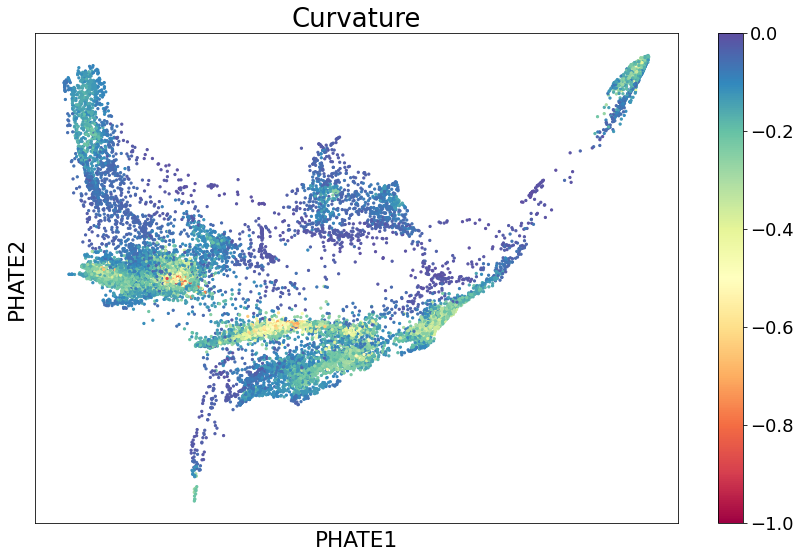

In [29]:
scprep.plot.scatter2d(Y_phate, c=-cc, figsize=(12,8), cmap=cmap,
                      ticks=False, label_prefix="PHATE", title = "Curvature", fontsize = 15, s = 5)

## Curvature potential

In [3]:
ebdata_2d = np.array(pd.read_csv('output/ebdata_2d.csv', sep=',', header=None))
ebdata_cur = np.array(pd.read_csv('output/ebdata_cc.csv', sep=',', header=None))
labels = np.array(pd.read_csv('output/ebdata_labels.csv', sep=',', header=None))

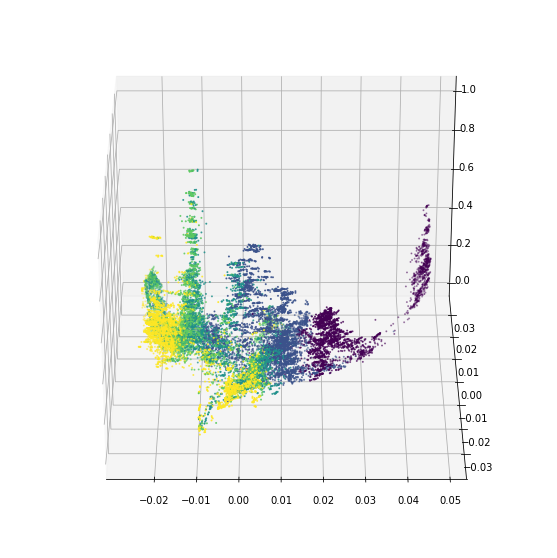

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(ebdata_2d[:,0], ebdata_2d[:,1], ebdata_cur[:,0], s=1, c=labels)
ax.view_init(elev=30, azim=-90)


In [5]:
eb_embed = np.concatenate([ebdata_2d, ebdata_cur], axis =1)

<AxesSubplot: xlabel='PHATE1', ylabel='PHATE2'>

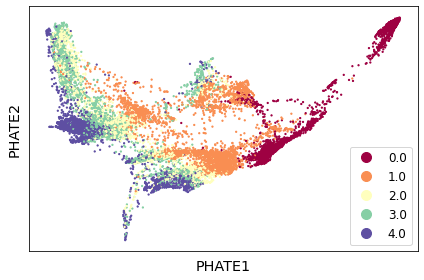

In [6]:
scprep.plot.scatter2d(ebdata_2d, c=labels, figsize=(6,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", filename="ebdata_2d_plot.png")

In [26]:
scprep.plot.rotate_scatter3d(eb_embed, c=labels, figsize=(8,6), cmap="Spectral",
                             ticks=False, filename="output/curvature_potential.gif")

MovieWriter imagemagick unavailable; using Pillow instead.


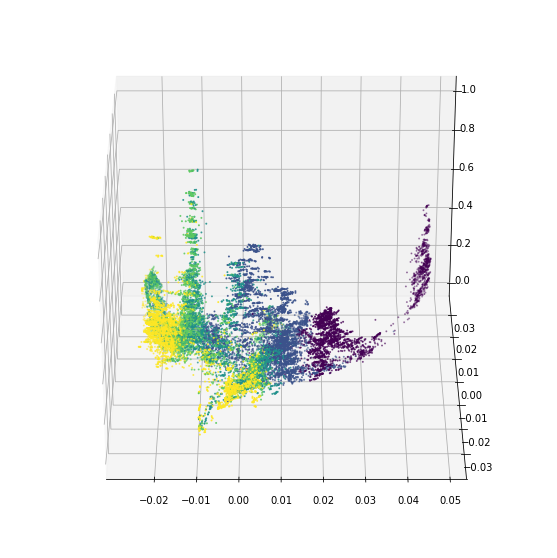

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(ebdata_2d[:,0], ebdata_2d[:,1], ebdata_cur[:,0], s=1, c=labels)
#ax.plot_surface(grid_x, grid_y, interpolated_z, alpha=0.5, cmap='viridis', label='Interpolated Surface')
ax.view_init(elev=30, azim=-90)

## Use GAE to reconstruct 

In [10]:
import torch
import sys
#sys.path.append("output/")

from models.vae import VAE
from models.train import train_vae

from torch.utils.data import DataLoader, TensorDataset
from models.jacobian import compute_jacobian
from models.visualize import visualize_jacobian_at_z0, visualize_jacobian_plane_at_z0, visualize_jacobian_plane_at_z0_schmidt

In [22]:
ebdata_2d = np.array(pd.read_csv('output/ebdata_2d.csv', sep=',', header=None))
ebdata_cur = np.array(pd.read_csv('output/ebdata_cc.csv', sep=',', header=None))
labels = np.array(pd.read_csv('output/ebdata_labels.csv', sep=',', header=None))
eb_with_cur = np.concatenate([ebdata_2d, ebdata_cur], axis =1)

In [21]:
ptt_tensor = torch.from_numpy(eb_with_cur).float()

ptt_dataset = TensorDataset(ptt_tensor)
ptt_dataloader = DataLoader(ptt_dataset, batch_size=1024, shuffle=False)

100%|██████████| 10000/10000 [19:54<00:00,  8.37it/s]


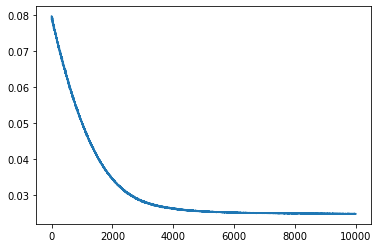

In [43]:
# Initialize the VAE with input_dim=5 and latent_dim=2
vae = VAE(input_dim=3, latent_dim=2, hidden_dim=64, activation="leaky_relu")

# Train the VAE
loss = train_vae(vae, ptt_dataloader, epochs=10000, learning_rate=1e-7, beta=0.3)
plt.plot(loss)

In [41]:
# Pass the hemisphere data through the VAE to get the reconstructed data
with torch.no_grad():
    reconstructed, mu, logvar = vae(ptt_tensor)
    reconstr_mean = vae.decoder(mu)

# Convert the reconstructed data to numpy for visualization
reconstructed_data = reconstructed.numpy()
latent_mu = mu
latent_mu_data = mu.numpy()
latent_logvar = logvar.numpy()
reconstr_mean = reconstr_mean.numpy()
reconstructed_data.shape

(16821, 3)

NameError: name 'reconstructed_data' is not defined

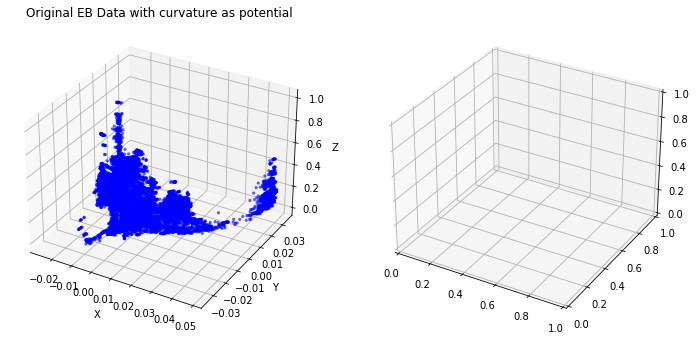

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

# Plot original data
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(ptt_tensor[:, 0], ptt_tensor[:, 1], ptt_tensor[:, 2], c='b', s = 5, alpha=0.5)
ax1.set_title("Original EB Data with curvature as potential")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
#ax1.set_xlim([-1, 1])
#ax1.set_ylim([-1, 1])
#ax1.set_zlim([0, 1])

# Plot reconstructed data
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], reconstructed_data[:, 2], c='r', s = 5, alpha=0.5)
ax2.set_title("Reconstructed Data from VAE")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
#ax2.set_xlim([-1, 1])
#ax2.set_ylim([-1, 1])
#ax2.set_zlim([0, 1])

plt.tight_layout()
plt.show()


106/106 [==============================] - 0s 736us/step - loss: 2.5111e-05
Mean Squared Error on Test Set: 2.51110213866923e-05
526/526 [==============================] - 0s 511us/step


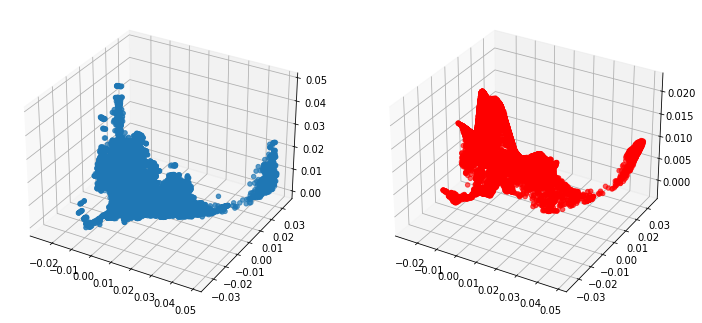

In [23]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Generate some sample data
np.random.seed(42)
num_samples = 1000
x = ebdata_2d
factor = max([max(x[:, 0]), max(x[:, 1])])
y = ebdata_cur/ max(ebdata_cur) * factor 



# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=0)

# Evaluate the model on the test set
loss = model.evaluate(x_test, y_test)
print(f'Mean Squared Error on Test Set: {loss}')

# Use the trained model to predict flow on a new set of points
new_points = x
predicted = model.predict(new_points)

# Visualize the predicted flow
# Visualize the surface
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(new_points[:, 0], new_points[:, 1], predicted, color='r', label='Predicted')
plt.show()


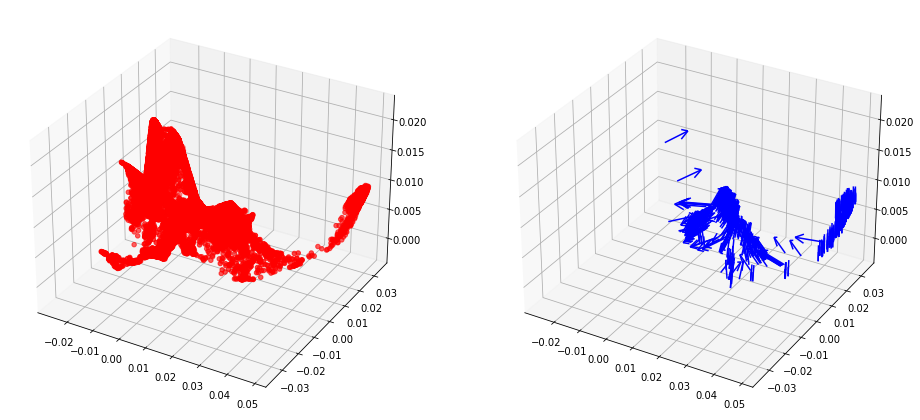

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ... (Previous code for data generation and model training)

# Function to compute the gradient using the model
def compute_gradient(model, point):
    point = tf.convert_to_tensor([point], dtype=tf.float32)  # Convert to a tf.Tensor
    with tf.GradientTape() as tape:
        tape.watch(point)
        prediction = model(point)
    gradient = tape.gradient(prediction, point)
    return gradient.numpy()[0]

# Visualize the predicted flow and gradient
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(new_points[:, 0], new_points[:, 1], predicted, marker='o', color='r', label='Predicted Flow')
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
z_lim = ax.get_zlim()

# Plotting the gradient arrows
ax = fig.add_subplot(122, projection='3d')
for point in new_points[:500]:
    gradient = compute_gradient(model, point)
    ax.quiver(point[0], point[1], model.predict(np.array([point]), verbose=0), -gradient[0], 
              -gradient[1], 0.01, color='b', length=0.01, normalize=True)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)

plt.show()

In [76]:
gradient[1]/np.linalg.norm(gradient)

0.9826095

In [81]:
predicted.shape

(16821, 1)

In [83]:
new_points

array([[ 0.0212228 , -0.00721472],
       [ 0.04622419,  0.0275421 ],
       [ 0.04390641,  0.02924139],
       ...,
       [-0.02230726,  0.00161441],
       [-0.02272502,  0.00148253],
       [-0.01877488, -0.00018587]])